# Binary Masking

In binary masking, each pixel in the binary mask has one of two values: ‘0’ representing the background, and ‘1’ or the maximum pixel intensity value i.e. ‘255’, corresponding to the image foreground. For the remainder of this discussion, we will use binary mask pixel values 0 and 1.

Whether the pixel value in the binary mask is assigned a 0 or 1 depends most often, on whether the associated image pixel value meets a designated or automatically selected threshold. Simply put, each pixel value $M_{i,j}$ in a binary mask $M$ is set to 0 if the corresponding pixel value $I_{i,j}$ in image $I$ is less than or equal to a threshold $T$, and set to 1 otherwise.

In other words:

```{math}
:label: global_threshold
M_{i,j} = \begin{cases}
1 & \text{if} I_{i,j} > T \\
0 & \text{if} I_{I,j} \le T \\
\end{cases}
```

where $I$ denotes the image and $M$ indicates the binary mask.

Setting an appropriate threshold is critically important. One that is too low tends to merge too many image structures, and a threshold that is too high may remove important structural data from the image.

To illustrate, let’s create a binary mask using threshold $T=127$.

NameError: name 'np' is not defined

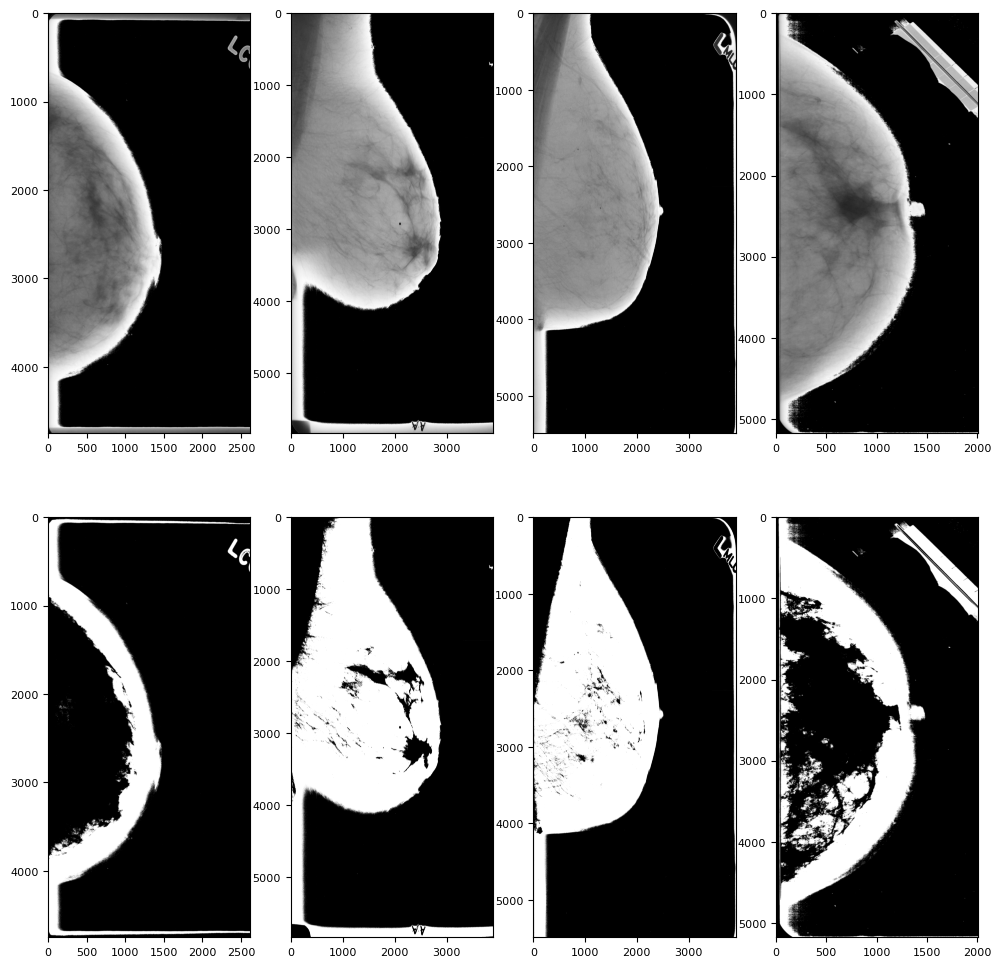

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import cv2
import matplotlib.pyplot as plt
from myst_nb import glue
from bcd.utils.image import convert_uint8

img1 = "data/image/2_exp/train/benign/2a44122c-f831-4220-95a8-408bcafcf2ce.png"
img2 = "data/image/2_exp/train/benign/3f72309d-7cd9-4e30-ae81-073adb541bcd.png"
img3 = "data/image/2_exp/train/benign/97556037-b959-4395-830b-380dcac2d58e.png"
img4 = "data/image/2_exp/train/malignant/6cdf46d8-596b-47ab-a428-c8769733c93c.png"

img1 = cv2.imread(img1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(img2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(img3, cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(img4, cv2.IMREAD_GRAYSCALE)

img1 = convert_uint8(img1)
img2 = convert_uint8(img2)
img3 = convert_uint8(img3)
img4 = convert_uint8(img4)

r, bm1 = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)
r, bm2 = cv2.threshold(img2, 127, 255, cv2.THRESH_BINARY)
r, bm3 = cv2.threshold(img3, 127, 255, cv2.THRESH_BINARY)
r, bm4 = cv2.threshold(img4, 127, 255, cv2.THRESH_BINARY)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,12))
_ = axes[0,0].imshow(img1, cmap='gray', aspect='auto')
_ = axes[0,1].imshow(img2, cmap='gray',aspect='auto')
_ = axes[0,2].imshow(img3, cmap='gray',aspect='auto')
_ = axes[0,3].imshow(img4, cmap='gray',aspect='auto')
_ = axes[1,0].imshow(bm1, cmap='gray', aspect='auto')
_ = axes[1,1].imshow(bm2, cmap='gray',aspect='auto')
_ = axes[1,2].imshow(bm3, cmap='gray',aspect='auto')
_ = axes[1,3].imshow(bm4, cmap='gray',aspect='auto')

labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"]])
for i in range(2):
    for j in range(4):
        _ = axes[i,j].set_xlabel(labels[i,j])
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("bm1", fig)

```{glue:figure} bm1
---
align: center
name: bm1_fig
---
Binary Masking with Threshold $T=127$
```

This simple binary mask {numref}`bm1_fig` shows how artifacts can be separated from the image; however, we lose detail in the breast tissue, indicating that our threshold is likely set to a value which is too high for this application.

## Automated Thresholding

Manually selecting a threshold value is often suboptimal due to bias that may be introduced. In many cases, especially in biomedical imaging, we want the threshold $T$ to be set automatically such that the pixels in the region of interest correspond most optimally to the ‘1’ pixel, and those in the background correspond to the ‘0’ pixel values in the binary mask. Literature is replete with automated binary threshold methods, most of which can be classified as either global thresholding or adaptive thresholding.

### Global Thresholding

One obvious way of segmenting artifacts from an image is via global thresholding; whereby, a threshold $T$ is selected as a pixel value between the minimum and maximum pixel values in the image. If $T$ applies to the entire image, the process is referred to as **global thresholding**.

#### Mean Thresholding

Mean thresholding provides an automated method for selecting a global threshold $T$ when the foreground and background regions are sufficiently distinct. For mean thresholding, the following iterative algorithm can serve this purpose:

1. Select an initial value for the global threshold $T$.
2. Segment the image using $T$ in {eq}`global_threshold`  to produce two regions $G_1$ consisting of pixel values > $T$, and $G_2$ consisting of pixel values $\le T$.
3. Compute the mean intensity values $m_1$, and $m_2$ for the pixels in $G_1$ and $G_2$, respectively.
4. Compute a new threshold $T$ midway between $m_1$ and $m_2$.
5. Repeat Steps 2 through 4 until the difference between successive values of $T$ is smaller than a predefined value, $\Delta T$.

Rather than computing these values iteratively, the image histogram can be used to more efficiently compute the global threshold $T$. Hence, the mean threshold method is often referred to as a **histogram shape-based** method.

Let's examine the binary mask created with Mean thresholding. The mean thresholding function takes a neighborhood size parameter, 11, and a constant $C=2$, which is subtracted from the mean to obtain the threshold $T$.

In [ ]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))

import cv2
import matplotlib.pyplot as plt
from myst_nb import glue
from bcd.utils.image import convert_uint8

bm1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)
bm2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)
bm3 = cv2.adaptiveThreshold(img3, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)
bm4 = cv2.adaptiveThreshold(img4, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,2)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,12))
_ = axes[0,0].imshow(img1, cmap='gray', aspect='auto')
_ = axes[0,1].imshow(img2, cmap='gray',aspect='auto')
_ = axes[0,2].imshow(img3, cmap='gray',aspect='auto')
_ = axes[0,3].imshow(img4, cmap='gray',aspect='auto')
_ = axes[1,0].imshow(bm1, cmap='gray', aspect='auto')
_ = axes[1,1].imshow(bm2, cmap='gray',aspect='auto')
_ = axes[1,2].imshow(bm3, cmap='gray',aspect='auto')
_ = axes[1,3].imshow(bm4, cmap='gray',aspect='auto')

labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"]])
for i in range(2):
    for j in range(4):
        _ = axes[i,j].set_xlabel(labels[i,j])
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("bm2", fig)

```{glue:figure} bm2
---
align: center
name: bm2_fig
---
Binary Masking with Threshold $T=127$
```

In {numref}`bm2_fig` we see.

#### Median Threshold

The Mean threshold method works well for images for which the histogram is bimodal. However, it is not robust to extreme gradients which may affect the mean pixel intensity values. An alternative is to use the *median* in step 3 instead of the mean.